<a href="https://colab.research.google.com/github/gracchen/bionics-lab-hand-plots/blob/main/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method
Below is the code to smooth (remove jumps), normalize (start at 0 degrees and use same y-range for sets of x,y,z plots), and plot all of the csv files for the first four hand tests. All the plots can be found in this google drive directory in the plots folder, either raw or normalized, sorted by test.

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)

folder = '/content/drive/My Drive/Bionics Lab Research/Grace/DataSet/'
data_path = folder + 'TendencyTest_07032024_Score2-1-0/score 2/'

Mounted at /content/drive


## Helper Functions to smooth and plot:

# Four-way Dist Plots

In [ ]:
# smoothen and plot:

def smooth_data(MotionData, col_name, normalize=False):
    """
    Takes the file dataframe and desired column to smooth (i.e. thumb01x)
    iterates through each element of the column (angle data) and smooths any
    jumps in the data with a constant being the difference between before and
    after the jump. Comment out the second last line to disable normalizing.
    """
    print(list(MotionData.columns))
    data = MotionData[col_name].copy()  # Create a copy of the column data
    i = 1
    while i < len(data):
      if abs(data[i-1] - data[i]) > 10:  # Jump detected
        constant = data[i-1] - data[i]
        data[i:] += constant
      i += 1

    if normalize: data -= data[0]
    MotionData[col_name] = data  # Update the column in the original DataFrame

def smooth_file(file_name, cols = None, normalize=False):
    """
    repeats smoothening for all desired columns (3 axes of 2 measured fingers)
    """
    print(f"reading {data_path+file_name}")
    MotionData = pd.read_csv(data_path+file_name)
    if cols is None:
      for finger in ['Thumb', 'Index']:
        for axis in ['x', 'y', 'z']:
          smooth_data(MotionData, finger+'01'+axis, normalize)
    else:
      for col in cols:
          smooth_data(MotionData, col, normalize)
    return MotionData

testnames = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction",  "PencilGrasp", "CylinderGrasp", "SphericalGrasp"]
def graph_file(file_name, test_name, hand, save_path = None):
    """
    generates smoothened plots of x,y,z for one csv file given path, test name,
    hand (left or right). If save_path defined, will save the plot as image in
    plots folder, otherwise will display it.
    """
    test_index = testnames.index(test_name)
    df = smooth_file(file_name, None)  # Smooth the data first

    # avoid scrolling if displaying one plot:
    from IPython.display import Javascript
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

    fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9),(ax10, ax11, ax12),(ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(30, 50), sharey='row') # increased height

    df, name11, name12 = compute_ratio(df, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
    smooth_data(df, 'Thumb_Hand_dist_ratio')
    df, name21, name22 = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
    smooth_data(df, 'Index_Hand_dist_ratio')
    df, name31, name32 = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
    smooth_data(df, 'Index_Thumb_dist_ratio')

    # degrees
    for finger, plts in zip(['Index', 'Thumb'], [[ax1,ax2,ax3],[ax4, ax5, ax6]]):
      for axis, plt_id in zip(['x','y','z'], plts):
        plt_id.plot(df['Timestamp'], df[finger + '01'+axis], label = finger + '1' + axis)
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = 'degrees')
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + axis + '-axis')

    # ratios
    for names,plts in zip([[name11,name12,'Thumb_Hand_dist_ratio'], [name21,name22,'Index_Hand_dist_ratio'], [name31,name32,'Index_Thumb_dist_ratio']], [[ax7,ax8,ax9], [ax10,ax11, ax12], [ax13,ax14,ax15]]):
      for ratio,plt_id,label in zip(names, plts, ['A','B','C']):
        plt_id.plot(df['Timestamp'], df[ratio], label = ratio)
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = label)
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + ratio)

    # show or save the image:
    if save_path is not None:
      file_prefix = os.path.splitext(file_name)[0] + "-ratios"  # Get the filename without extension
      os.makedirs(save_path, exist_ok=True)
      save_file_path = os.path.join(save_path, f"{test_index}{file_prefix}.png")
      print(f"saving to {save_file_path}")
      plt_id.figure.savefig(save_file_path)
      plt.close()  # to avoid showing a bajillion plots
    else:
      plt.show()

    return


def graph_files(file_names, test_name, hand, save_path = None, name = None, normalize = False):
    """
    generates smoothened plots of x,y,z for one csv file given path, test name,
    hand (left or right). If save_path defined, will save the plot as image in
    plots folder, otherwise will display it.
    """
    test_index = testnames.index(test_name)

    dfs = []
    for file_name in file_names:
      df = smooth_file(file_name, None, normalize)  # Smooth the data first
      df, name11, name12 = compute_ratio(df, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
      smooth_data(df, 'Thumb_Hand_dist_ratio', normalize)
      df, name21, name22 = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
      smooth_data(df, 'Index_Hand_dist_ratio', normalize)
      df, name31, name32 = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
      smooth_data(df, 'Index_Thumb_dist_ratio', normalize)
      dfs.append(df)

    # avoid scrolling if displaying one plot:
    from IPython.display import Javascript
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

    fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9),(ax10, ax11, ax12),(ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(30, 50), sharey='row') # increased height

    # degrees
    for finger, plts in zip(['Index', 'Thumb'], [[ax1,ax2,ax3],[ax4, ax5, ax6]]):
      for axis, plt_id in zip(['x','y','z'], plts):
        for i, df in enumerate(dfs):
          plt_id.plot(df['Timestamp'], df[finger + '01'+axis], label = str(i+1))
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = 'degrees')
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + axis + '-axis')

    # ratios
    for names,plts in zip([[name11,name12,'Thumb_Hand_dist_ratio'], [name21,name22,'Index_Hand_dist_ratio'], [name31,name32,'Index_Thumb_dist_ratio']], [[ax7,ax8,ax9], [ax10,ax11, ax12], [ax13,ax14,ax15]]):
      for ratio,plt_id,label in zip(names, plts, ['A','B','C']):
        for i, df in enumerate(dfs):
          plt_id.plot(df['Timestamp'], df[ratio], label = str(i+1))
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = label)
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + ratio)

    # show or save the image:
    if save_path is not None:
      if name is None:
        file_prefix = os.path.splitext(file_name)[0] # Get the filename without extension
        save_file_path = os.path.join(save_path, f"{file_prefix}_{'relative' if normalize else 'absolute'}.png")
      else:
        save_file_path = os.path.join(save_path, f"{name}.png")

      os.makedirs(save_path, exist_ok=True)
      print(f"saving to {save_file_path}")
      plt_id.figure.savefig(save_file_path)
      plt.close()  # to avoid showing a bajillion plots
    else:
      plt.show()

    return

In [ ]:
# general func to compute dist(base, joint2) / dist(base, joint1)
def compute_ratio(file, base, joint1, joint2, output):
  if isinstance(file, str):
    df = pd.read_csv(folder+file)
  else: df = file
  shape = df['Handx'].shape
  for joint in [base, joint1, joint2]:
    for axis in ['x', 'y', 'z']:
      smooth_data(df, joint+axis)

  base_dfs = [df[base+'x'],df[base+'y'],df[base+'z']]
  joint1_dfs = [df[joint1+'x'],df[joint1+'y'],df[joint1+'z']]
  joint2_dfs = [df[joint2+'x'],df[joint2+'y'],df[joint2+'z']]

  dist1 = np.sqrt((joint1_dfs[0] - base_dfs[0])**2 + (joint1_dfs[1] - base_dfs[1])**2 + (joint1_dfs[2] - base_dfs[2])**2)
  dist2 = np.sqrt((joint2_dfs[0] - base_dfs[0])**2 + (joint2_dfs[1] - base_dfs[1])**2 + (joint2_dfs[2] - base_dfs[2])**2)

  base = base[0:-1] if base[-1] == '_' else base
  joint1 = joint1[0:-1] if joint1[-1] == '_' else joint1
  joint2 = joint2[0:-1] if joint2[-1] == '_' else joint2

  df[base + "—" + joint1 + "_dist"] = dist1
  df[base + "—" + joint2 + "_dist"] = dist2
  df[output] = np.where(dist1 != 0, dist2 / dist1, 0)
  return df, (base + "—" + joint1 + "_dist"), (base + "—" + joint2 + "_dist")

In [ ]:
# grab all the csvs and divide into filenames[test#][right/left] dictionary
folder = '/content/drive/My Drive/Bionics Lab Research/Grace/'
data_path = folder + 'DataSet/TendencyTest_07032024_Score2-1-0/score 1/'
file_list = os.listdir(data_path)

filenames = {}
testnames = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction",  "PencilGrasp", "CylinderGrasp", "SphericalGrasp"]
for testname, testno in zip(testnames, range(0,len(testnames))):
    filenames[testno] = {'right': [filename for filename in file_list if testname in filename and 'Right' in filename and 'meta' not in filename],
                        'left': [filename for filename in file_list if testname in filename and 'Left' in filename and 'meta' not in filename]}
    save_folder = os.path.join(folder, f"Tendency Test - 2024-07-03/score 1")
    os.makedirs(save_folder, exist_ok=True)

for testno in range(0,len(testnames)):
    graph_files(filenames[testno]['right'], testnames[testno], "Right",  save_path=save_folder, name=f"Right_{testnames[testno]}_absolute", normalize=False)
    graph_files(filenames[testno]['right'], testnames[testno], "Right",  save_path=save_folder, name=f"Right_{testnames[testno]}_relative", normalize=True)
    graph_files(filenames[testno]['left'], testnames[testno], "Left",  save_path=save_folder, name=f"Left_{testnames[testno]}_absolute", normalize=False)
    graph_files(filenames[testno]['left'], testnames[testno], "Left",  save_path=save_folder, name=f"Left_{testnames[testno]}_relative", normalize=True)
    graph_files(filenames[testno]['right'] + filenames[testno]['left'], testnames[testno], "Both Hands",  save_path=save_folder, name=f"Both_{testnames[testno]}_absolute", normalize=False)
    graph_files(filenames[testno]['right'] + filenames[testno]['left'], testnames[testno], "Both Hands",  save_path=save_folder, name=f"Both_{testnames[testno]}_relative", normalize=True)


folder = '/content/drive/My Drive/Bionics Lab Research/Grace/'
data_path = folder + 'DataSet/TendencyTest_07032024_Score2-1-0/score 0/'
file_list = os.listdir(data_path)

filenames = {}
testnames = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction",  "PencilGrasp", "CylinderGrasp", "SphericalGrasp"]
for testname, testno in zip(testnames, range(0,len(testnames))):
    filenames[testno] = {'right': [filename for filename in file_list if testname in filename and 'Right' in filename and 'meta' not in filename],
                        'left': [filename for filename in file_list if testname in filename and 'Left' in filename and 'meta' not in filename]}
    save_folder = os.path.join(folder, f"Tendency Test - 2024-07-03/score 0")
    os.makedirs(save_folder, exist_ok=True)

for testno in range(0,len(testnames)):
    graph_files(filenames[testno]['right'], testnames[testno], "Right",  save_path=save_folder, name=f"Right_{testnames[testno]}_absolute", normalize=False)
    graph_files(filenames[testno]['right'], testnames[testno], "Right",  save_path=save_folder, name=f"Right_{testnames[testno]}_relative", normalize=True)
    graph_files(filenames[testno]['left'], testnames[testno], "Left",  save_path=save_folder, name=f"Left_{testnames[testno]}_absolute", normalize=False)
    graph_files(filenames[testno]['left'], testnames[testno], "Left",  save_path=save_folder, name=f"Left_{testnames[testno]}_relative", normalize=True)
    graph_files(filenames[testno]['right'] + filenames[testno]['left'], testnames[testno], "Both Hands",  save_path=save_folder, name=f"Both_{testnames[testno]}_absolute", normalize=False)
    graph_files(filenames[testno]['right'] + filenames[testno]['left'], testnames[testno], "Both Hands",  save_path=save_folder, name=f"Both_{testnames[testno]}_relative", normalize=True)

reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_40MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_44MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_47MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_52MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_58MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_28_01MassFlexion_6.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/Ten

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_MassFlexion_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_40MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_44MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_47MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_52MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_58MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_MassFlexion_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_19MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_27MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_32MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_37MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_41MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_MassFlexion_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_19MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_27MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_32MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_37MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_43_41MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/scor

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_MassFlexion_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_40MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_44MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_47MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_52MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_58MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_MassFlexion_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_40MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_44MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_47MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_52MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_27_58MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_MassFlexion_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_14MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_18MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_22MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_25MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_29MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_MassExtension_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_14MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_18MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_22MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_25MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_29MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_MassExtension_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_34MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_38MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_43MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_48MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_51MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sc

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_MassExtension_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_34MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_38MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_43MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_48MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_44_51MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_MassExtension_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_14MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_18MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_22MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_25MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_29MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_MassExtension_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_14MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_18MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_22MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_25MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_29_29MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_MassExtension_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_05HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_11HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_16HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_22HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_28HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_HookGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_05HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_11HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_16HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_22HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_28HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/Ri

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_HookGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_13HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_18HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_23HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_29HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_34HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHan

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_HookGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_13HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_18HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_23HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_29HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_46_34HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_HookGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_05HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_11HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_16HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_22HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_28HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/Rig

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_HookGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_05HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_11HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_16HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_22HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_11_16_28HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/Rig

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_HookGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_37ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_45ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_52ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_58ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_35_04ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_ThumbAdduction_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_37ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_45ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_52ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_58ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_35_04ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_ThumbAdduction_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_22ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_29ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_33ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_39ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_44ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_ThumbAdduction_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_22ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_29ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_33ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_39ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_47_44ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_ThumbAdduction_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_37ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_45ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_52ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_58ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_35_04ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_ThumbAdduction_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_37ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_45ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_52ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_34_58ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_35_04ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_ThumbAdduction_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_12PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_19PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_28PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_34PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_39PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_PencilGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_12PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_19PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_28PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_34PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_39PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_PencilGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_32PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_36PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_40PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_44PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_48PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_PencilGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_32PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_36PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_40PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_44PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_48_48PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/scor

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_PencilGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_12PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_19PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_28PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_34PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_39PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_PencilGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_12PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_19PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_28PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_34PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_36_39PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_PencilGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_37_54CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_00CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_05CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_09CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_13CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_CylinderGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_37_54CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_00CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_05CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_09CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_13CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_CylinderGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_21CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_27CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_32CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_38CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_44CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sc

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_CylinderGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_21CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_27CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_32CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_38CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_49_44CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_CylinderGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_37_54CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_00CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_05CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_09CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_13CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_CylinderGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_37_54CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_00CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_05CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_09CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_38_13CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_CylinderGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_38SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_45SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_50SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_54SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_59SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_SphericalGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_38SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_45SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_50SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_54SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_59SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Right_SphericalGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_14SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_20SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_24SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_29SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_34SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_SphericalGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_14SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_20SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_24SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_29SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/LeftHand_07_03_2024_11_51_34SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Left_SphericalGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_38SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_45SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_50SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_54SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_59SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_SphericalGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_38SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_45SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_50SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_54SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 1/RightHand_07_03_2024_10_39_59SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 1/Both_SphericalGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_33MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_39MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_43MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_51MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_56MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_MassFlexion_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_33MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_39MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_43MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_51MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_56MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_MassFlexion_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_39MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_44MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_47MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_51MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_55MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_MassFlexion_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_39MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_44MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_47MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_51MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_53_55MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/scor

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_MassFlexion_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_33MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_39MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_43MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_51MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_56MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_MassFlexion_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_33MassFlexion_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_39MassFlexion_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_43MassFlexion_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_51MassFlexion_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_43_56MassFlexion_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_MassFlexion_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_27MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_31MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_35MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_38MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_42MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_MassExtension_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_27MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_31MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_35MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_38MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_42MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_MassExtension_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_34MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_39MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_42MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_46MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_50MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sc

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_MassExtension_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_34MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_39MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_42MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_46MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_54_50MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_MassExtension_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_27MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_31MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_35MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_38MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_42MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_MassExtension_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_27MassExtension_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_31MassExtension_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_35MassExtension_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_38MassExtension_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_46_42MassExtension_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_MassExtension_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_40HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_42HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_45HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_48HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_53HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_HookGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_40HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_42HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_45HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_48HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_53HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/Ri

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_HookGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_42HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_46HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_53HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_59HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_56_04HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHan

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_HookGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_42HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_46HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_53HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_55_59HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_56_04HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_HookGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_40HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_42HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_45HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_48HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_53HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/Rig

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_HookGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_40HookGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_42HookGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_45HookGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_48HookGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_49_53HookGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/Rig

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_HookGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_50_57ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_01ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_05ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_10ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_14ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_ThumbAdduction_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_50_57ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_01ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_05ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_10ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_14ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_ThumbAdduction_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_10ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_14ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_19ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_23ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_28ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_ThumbAdduction_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_10ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_14ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_19ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_23ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_57_28ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_ThumbAdduction_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_50_57ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_01ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_05ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_10ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_14ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_ThumbAdduction_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_50_57ThumbAdduction_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_01ThumbAdduction_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_05ThumbAdduction_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_10ThumbAdduction_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_51_14ThumbAdduction_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_ThumbAdduction_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_15PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_22PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_26PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_35PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_54PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_PencilGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_15PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_22PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_26PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_35PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_54PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_PencilGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_18PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_23PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_28PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_34PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_42PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_PencilGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_18PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_23PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_28PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_34PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_58_42PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/scor

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_PencilGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_15PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_22PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_26PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_35PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_54PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_PencilGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_15PencilGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_22PencilGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_26PencilGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_35PencilGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_52_54PencilGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_PencilGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_36CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_39CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_43CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_47CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_51CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_CylinderGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_36CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_39CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_43CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_47CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_51CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_CylinderGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_33CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_39CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_46CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_54CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_00_01CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sc

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_CylinderGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_33CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_39CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_46CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_11_59_54CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_00_01CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Sco

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_CylinderGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_36CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_39CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_43CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_47CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_51CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_CylinderGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_36CylinderGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_39CylinderGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_43CylinderGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_47CylinderGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_54_51CylinderGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0703202

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_CylinderGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_47SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_50SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_55SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_00SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_04SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_SphericalGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_47SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_50SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_55SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_00SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_04SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Right_SphericalGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_02SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_08SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_15SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_22SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_28SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_SphericalGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_02SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_08SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_15SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_22SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/LeftHand_07_03_2024_12_01_28SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_070320

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Left_SphericalGrasp_relative.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_47SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_50SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_55SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_00SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_04SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_SphericalGrasp_absolute.png
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_47SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_50SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_55_55SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_00SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 0/RightHand_07_03_2024_10_56_04SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_0

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Tendency Test - 2024-07-03/score 0/Both_SphericalGrasp_relative.png


In [ ]:
datapath = '/content/drive/My Drive/Bionics Lab Research/Grace/DataSet'
root, dirs, files = os.walk(folder).__next__()
tests = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction",  "PencilGrasp", "CylinderGrasp", "SphericalGrasp"]

filenames = {test: [] for test in tests}

for subject in dirs:
    csvs = os.listdir(os.path.join(folder, subject))
    for test in tests:
        filenames[test] = filenames[test] + [subject+"/"+filename for filename in csvs if test in filename and 'meta' not in filename]

filenames

{'MassFlexion': ['ID03_07022024_AffectedRight/LeftHand_07_02_2024_14_01_26_1MassFlexion.csv',
  'ID03_07022024_AffectedRight/LeftHand_07_02_2024_14_01_19_1MassFlexion.csv',
  'ID02_06182024_AffectedLeft/RightHand_06_18_2024_11_21_58_1MassFlexion.csv',
  'ID02_06182024_AffectedLeft/RightHand_06_18_2024_11_21_40_1MassFlexion.csv',
  'ID01_05022024_AffectedLeft/RightHand_05_02_2024_13_25_19_1MassFlexion.csv',
  'ID01_05022024_AffectedLeft/RightHand_05_02_2024_13_25_10_1MassFlexion.csv',
  'ID01_05022024_AffectedLeft/RightHand_05_02_2024_13_26_01_1MassFlexion.csv',
  'ID01_05022024_AffectedLeft/RightHand_05_02_2024_13_25_56_1MassFlexion.csv',
  'IDH01_05182024_Healthy/LeftHand_05_18_2024_14_34_26_1MassFlexion.csv',
  'IDH01_05182024_Healthy/LeftHand_05_18_2024_14_34_30_1MassFlexion.csv',
  'IDH01_05182024_Healthy/RightHand_05_18_2024_14_26_40_1MassFlexion.csv',
  'IDH01_05182024_Healthy/RightHand_05_18_2024_14_26_46_1MassFlexion.csv',
  'HandSensorData_05242024_Healthy/RightHand_05_24_2024

In [ ]:
def graph_files(file_names, test_name, save_path = None, name = None, normalize = False):
    """
    generates smoothened plots of x,y,z for one csv file given path, test name,
    hand (left or right). If save_path defined, will save the plot as image in
    plots folder, otherwise will display it.
    """
    test_index = testnames.index(test_name)

    dfs = []
    for file_name in file_names:
      df = smooth_file(file_name, None, normalize)  # Smooth the data first
      df, name11, name12 = compute_ratio(df, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
      smooth_data(df, 'Thumb_Hand_dist_ratio', normalize)
      df, name21, name22 = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
      smooth_data(df, 'Index_Hand_dist_ratio', normalize)
      df, name31, name32 = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
      smooth_data(df, 'Index_Thumb_dist_ratio', normalize)
      dfs.append(df)

    # avoid scrolling if displaying one plot:
    from IPython.display import Javascript
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

    fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9),(ax10, ax11, ax12),(ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(30, 50), sharey='row') # increased height

    # degrees
    for finger, plts in zip(['Index', 'Thumb'], [[ax1,ax2,ax3],[ax4, ax5, ax6]]):
      for axis, plt_id in zip(['x','y','z'], plts):
        for i, df in enumerate(dfs):
          plt_id.plot(df['Timestamp'], df[finger + '01'+axis], label = str(i+1))
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = 'degrees')
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + axis + '-axis')

    # ratios
    for names,plts in zip([[name11,name12,'Thumb_Hand_dist_ratio'], [name21,name22,'Index_Hand_dist_ratio'], [name31,name32,'Index_Thumb_dist_ratio']], [[ax7,ax8,ax9], [ax10,ax11, ax12], [ax13,ax14,ax15]]):
      for ratio,plt_id,label in zip(names, plts, ['A','B','C']):
        for i, df in enumerate(dfs):
          plt_id.plot(df['Timestamp'], df[ratio], label = str(i+1))
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = label)
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + ratio)

    # show or save the image:
    if save_path is not None:
      if name is None:
        file_prefix = os.path.splitext(file_name)[0] # Get the filename without extension
        save_file_path = os.path.join(save_path, f"{file_prefix}_{'relative' if normalize else 'absolute'}.png")
      else:
        save_file_path = os.path.join(save_path, f"{name}.png")

      os.makedirs(save_path, exist_ok=True)
      print(f"saving to {save_file_path}")
      plt_id.figure.savefig(save_file_path)
      plt.close()  # to avoid showing a bajillion plots
    else:
      plt.show()

    return

In [ ]:
graph_files(filenames['MassFlexion'], 'MassFlexion', save_path = '/content/drive/My Drive/Bionics Lab Research/Grace/', name="Mass_Flexion", normalize=True)

reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/ID03_07022024_AffectedRight/LeftHand_07_02_2024_14_01_26_1MassFlexion.csv
['Timestamp', 'Handx', 'Handy', 'Handz', 'Thumb01x', 'Thumb01y', 'Thumb01z', 'Thumb02x', 'Thumb02y', 'Thumb02z', 'Thumb03x', 'Thumb03y', 'Thumb03z', 'Index01x', 'Index01y', 'Index01z', 'Index02x', 'Index02y', 'Index02z', 'Index03x', 'Index03y', 'Index03z', 'Middle01x', 'Middle01y', 'Middle01z', 'Middle02x', 'Middle02y', 'Middle02z', 'Middle03x', 'Middle03y', 'Middle03z', 'Ring01x', 'Ring01y', 'Ring01z', 'Ring02x', 'Ring02y', 'Ring02z', 'Ring03x', 'Ring03y', 'Ring03z', 'Pinky01x', 'Pinky01y', 'Pinky01z', 'Pinky02x', 'Pinky02y', 'Pinky02z', 'Pinky03x', 'Pinky03y', 'Pinky03z', 'LAx', 'LAy', 'LAz', 'Index_quat_x', ' Index_quat_y', ' Index_quat_z', ' Index_quat_w', 'Thumb_quat_x', ' Thumb_quat_y', ' Thumb_quat_z', ' Thumb_quat_w', 'Hand_quat_x', ' Hand_quat_y', ' Hand_quat_z', ' Hand_quat_w', 'Index_quat_cal_x', ' Index_quat_cal_y', ' Index_quat_cal_z'

KeyError: 'Hand_pos_x'

In [ ]:
 graph_files(filenames[6]['right'], 'SphericalGrasp', "Right", save_path = '/content/drive/My Drive/Bionics Lab Research/Grace/', name="Right_SphericalGrasp_relative", normalize=True)

reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_22_05SphericalGrasp_1.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_22_12SphericalGrasp_2.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_22_19SphericalGrasp_3.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_22_33SphericalGrasp_4.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_22_39SphericalGrasp_5.csv
reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_22_45SphericalGrasp_6.csv
reading /content/drive/My Drive/Bionics Lab Research

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/Right_SphericalGrasp_relative.png


reading /content/drive/My Drive/Bionics Lab Research/Grace/DataSet/TendencyTest_07032024_Score2-1-0/score 2/RightHand_07_03_2024_10_23_17SphericalGrasp_10.csv


<IPython.core.display.Javascript object>

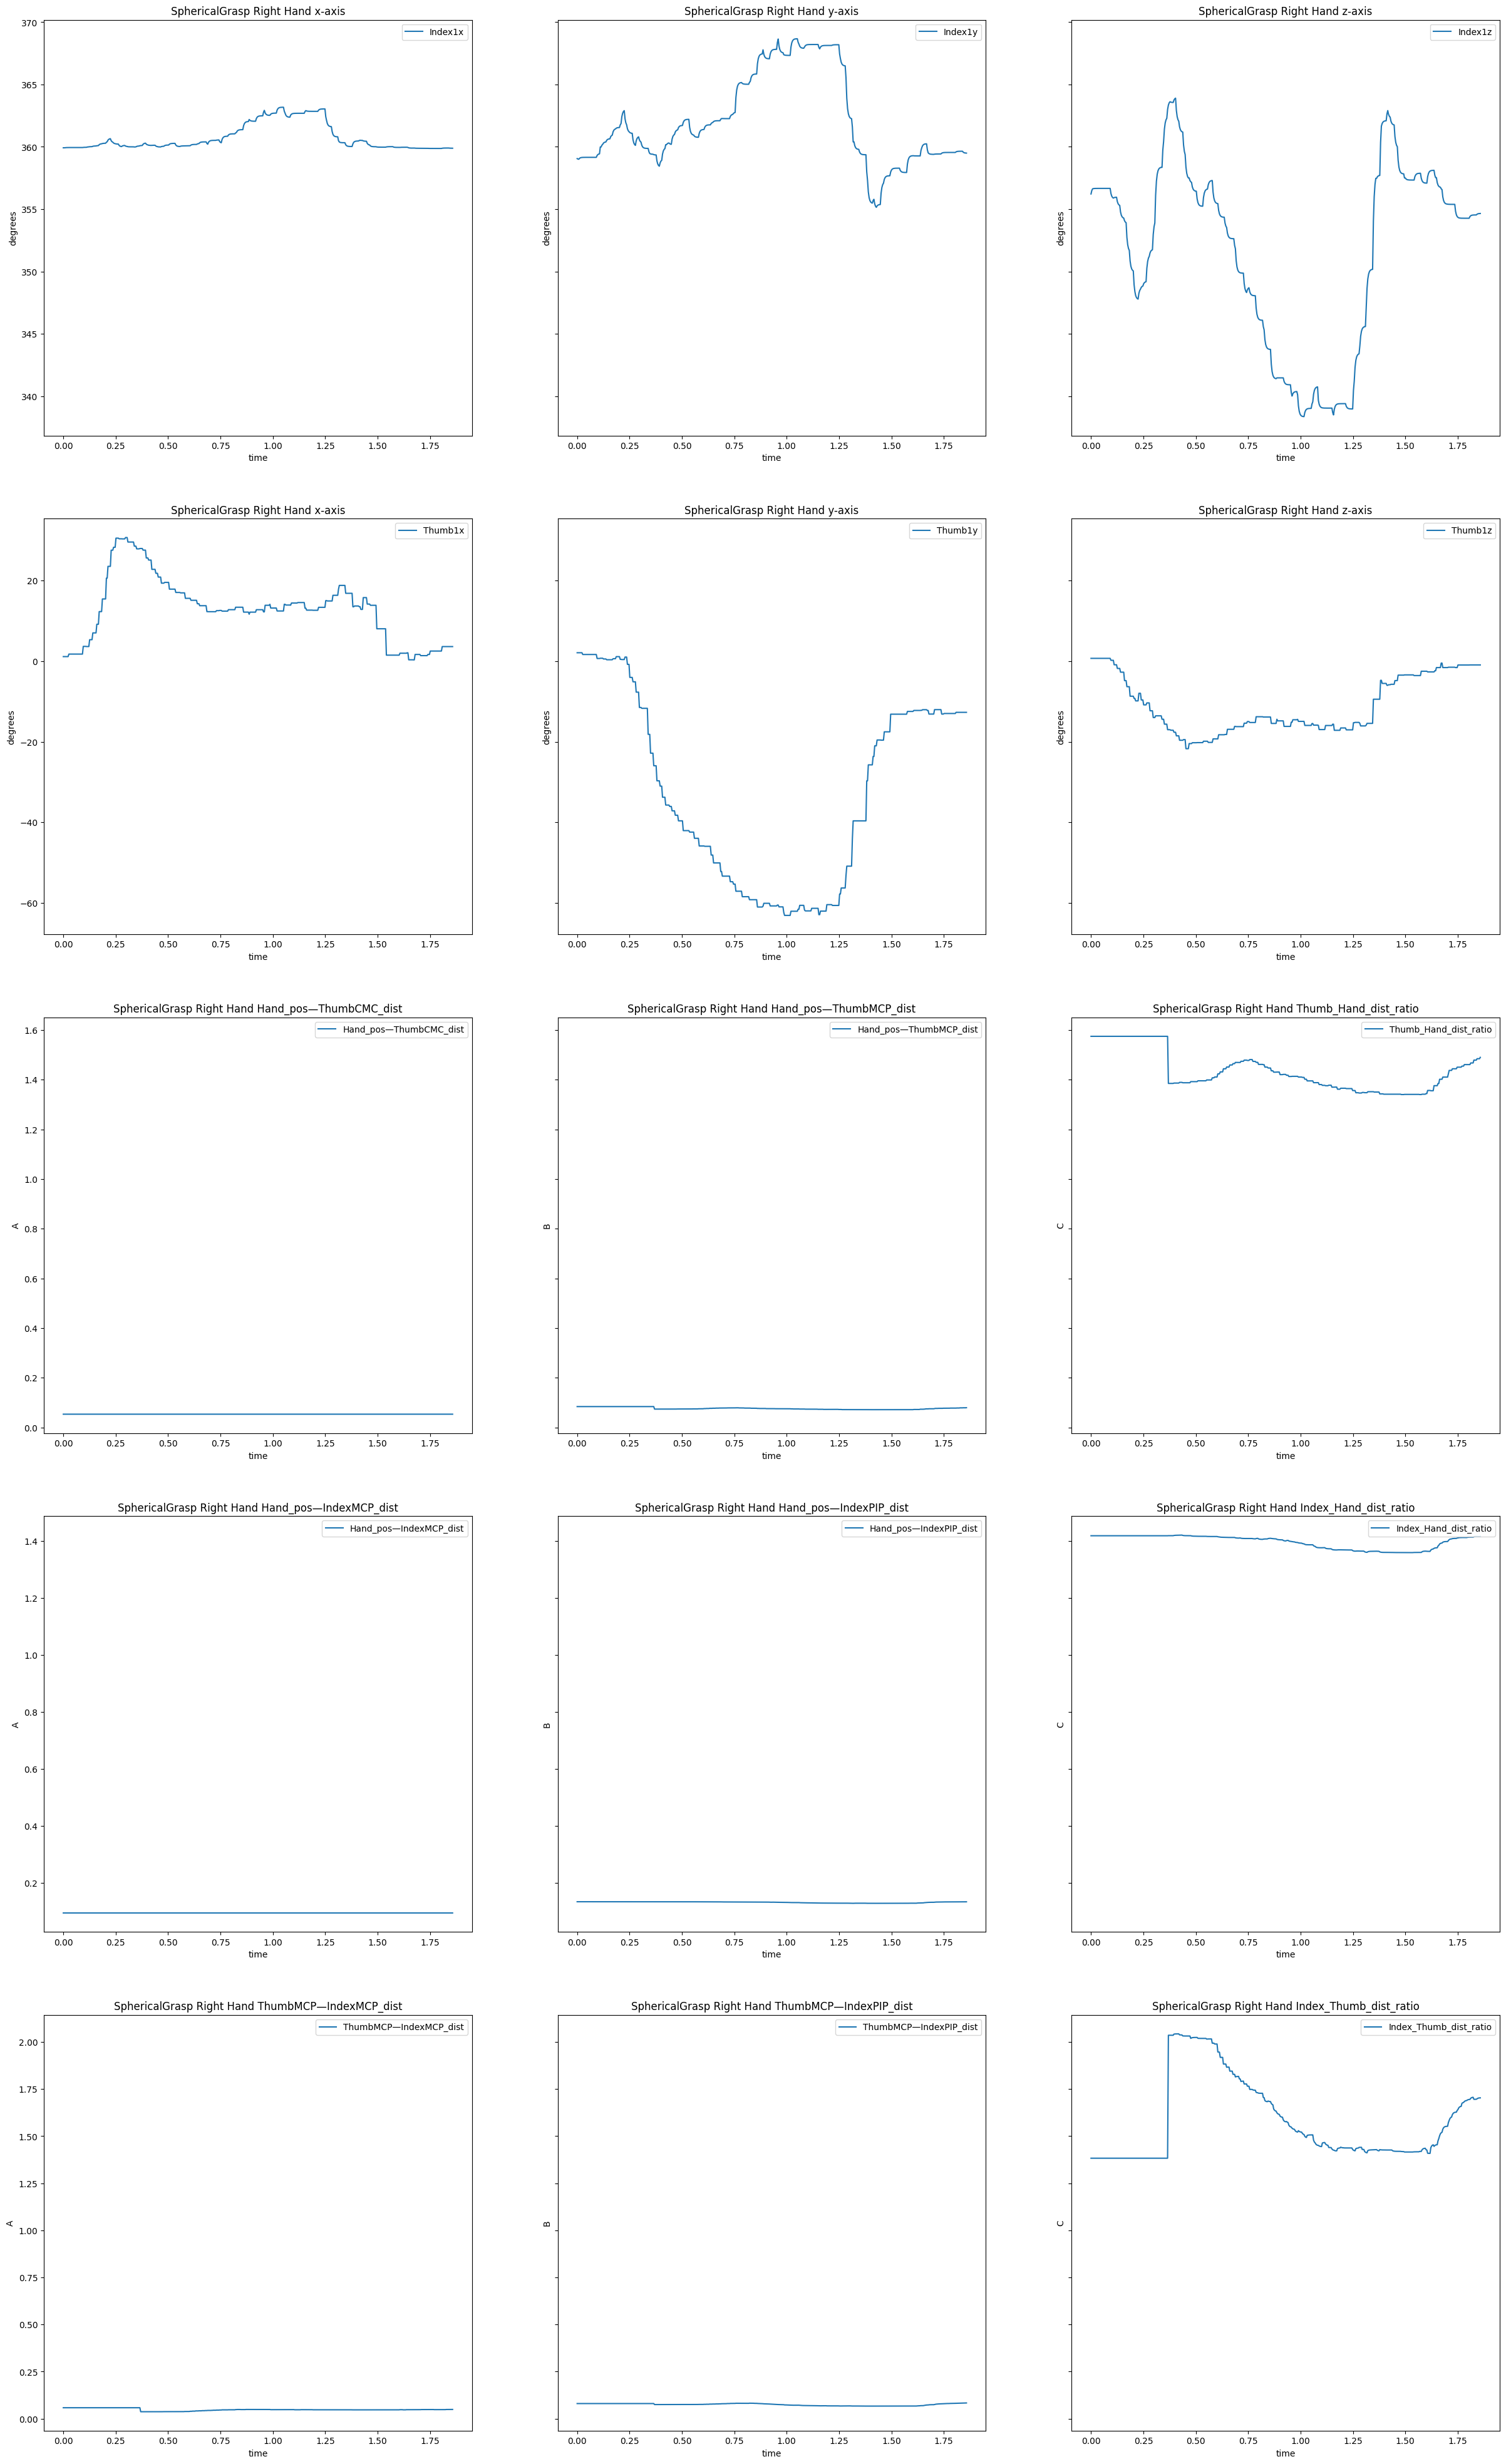

In [ ]:
df = graph_file('RightHand_07_03_2024_10_23_17SphericalGrasp_10.csv', 'SphericalGrasp', "Right")

In [ ]:
# generate and save batch of all plots:
for testno in range(len(testnames)):
    for hand in ['right', 'left']:
        for file_name in filenames[testno][hand]:
            save_folder = os.path.join(folder, f"Grace/plots-6-28/")
            os.makedirs(save_folder, exist_ok=True)
            graph_file(file_name, testnames[testno], hand.capitalize(), save_path=save_folder, plot_ratios=True)
            #print(f"graph_file({file_name}, {testnames[testno]}, {hand.capitalize()}, {save_folder})")

TypeError: graph_file() got an unexpected keyword argument 'plot_ratios'

# Distance Ratio plots


In [ ]:
folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/'
example_file = 'HandSensorData_05312024/Grace/10 - upper arm left right/LeftHand_05_31_2024_15_11_10_1MassFlexion.csv'

# hand_pos to thumb_mcp / hand_pos to thumb_cmc
df = compute_ratio(example_file, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
# hand_pos to index_pip / hand_pos to index_mcp
df = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
# thumb_mcp to index_pip / thumb_mcp to index_mcp
df = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')

(456,)
(456,)
(456,)


In [ ]:
df = compute_ratio("FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/"+"LeftHand_06_18_2024_11_39_57_6CylinderGrasp.csv", 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
df.to_csv(folder+'/file.csv', index = None)

In [ ]:
# grab all the csvs and divide into filenames[test#][right/left] dictionary
dest_folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802_dist_ratios/'

import os
file_list = os.listdir(data_path)

for filename in file_list:
  # hand_pos to thumb_mcp / hand_pos to thumb_cmc
  df = compute_ratio("FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/"+filename, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
  # hand_pos to index_pip / hand_pos to index_mcp
  df = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
  # thumb_mcp to index_pip / thumb_mcp to index_mcp
  df = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
  #write new csv
  os.makedirs(dest_folder, exist_ok=True)
  df.to_csv(dest_folder+filename, index = None)
